## STUDENT INFORMATION

BITS ID: 2025AA05368

Name: TUSHAR GANGERA

Email: 2025aa05368@wilp.bits-pilani.ac.in

Date: 14-02-2025

## Problem Statement

This project aimed to develop and evaluate several machine learning classification models to predict the Carbon Monoxide (CO) level in the atmosphere. The CO level was categorized into 'low', 'medium', and 'high' based on quantiles of the CO(GT) concentration from the Air Quality dataset. The goal was to build an interactive Streamlit web application to demonstrate these models and their performance.

## Dataset Description

The dataset used was the "Air Quality (UCI)" dataset, sourced from the UCI Machine Learning Repository. It contains measurements of various air pollutants and meteorological parameters recorded hourly from March 2004 to February 2005 in an Italian city. Key features included:

*   `CO(GT)`: True hourly averaged CO concentration (mg/m^3)
*   `PT08.S1(CO)`: Tin oxide sensor response (CO)
*   `C6H6(GT)`: True hourly averaged Benzene concentration (microg/m^3)
*   `PT08.S2(NMHC)`: Titania sensor response (NMHC)
*   `NOx(GT)`: True hourly averaged NOx concentration (microg/m^3)
*   `PT08.S3(NOx)`: Tungsten oxide sensor response (NOx)
*   `NO2(GT)`: True hourly averaged NO2 concentration (microg/m^3)
*   `PT08.S4(NO2)`: Tungsten oxide sensor response (NO2)
*   `PT08.S5(O3)`: Indium oxide sensor response (O3)
*   `T`: Temperature (°C)
*   `RH`: Relative Humidity (%)
*   `AH`: Absolute Humidity (AH)

The target variable, `CO_Level`, is a categorical variable derived from `CO(GT)` and classified into 'low', 'medium', and 'high' based on quantiles.

## Importing Required Libraries

In [21]:
import pandas as pd
import numpy as np
import os
import joblib
import importlib.metadata
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef, classification_report, confusion_matrix)
import joblib

print("All necessary libraries imported successfully.")

All necessary libraries imported successfully.


## Dataset Description

Load the 'AirQualityUCI.csv' file and provide a detailed description of its features, data types, and initial observations. This includes identifying placeholder missing values (-200) and noting columns like 'Date' and 'Time' for necessary conversions.

In [22]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Reload the original DataFrame to ensure 'Date' and 'Time' columns are present
df = pd.read_csv('AirQualityUCI.csv', sep=';')

# 1. Replace all occurrences of the placeholder value -200 with np.nan
df.replace(-200, np.nan, inplace=True)

# 2. Drop the 'Unnamed: 15' and 'Unnamed: 16' columns if they exist
columns_to_drop = ['Unnamed: 15', 'Unnamed: 16']
existing_columns_to_drop = [col for col in columns_to_drop if col in df.columns]
if existing_columns_to_drop:
    df.drop(columns=existing_columns_to_drop, inplace=True)

# 3. Convert specified columns from object type to numeric (replacing ',' with '.')
columns_to_clean = ['CO(GT)', 'C6H6(GT)', 'T', 'RH', 'AH']
for col in columns_to_clean:
    if col in df.columns:
        df[col] = df[col].astype(str).str.replace(',', '.', regex=False).astype(float)

# 4. Create a new 'DateTime' column by combining 'Date' and 'Time'
df['DateTime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S', errors='coerce')

# Drop rows where DateTime conversion failed (if any)
df.dropna(subset=['DateTime'], inplace=True)

# 5. Extract temporal features
df['hour'] = df['DateTime'].dt.hour
df['day_of_week'] = df['DateTime'].dt.dayofweek
df['day_of_year'] = df['DateTime'].dt.dayofyear
df['month'] = df['DateTime'].dt.month

# 6. Drop original 'Date', 'Time', 'DateTime' and 'NMHC(GT)' columns
df.drop(columns=['Date', 'Time', 'DateTime', 'NMHC(GT)'], inplace=True)

# 7. Fill any remaining missing values using forward fill (ffill()) and backfill (bfill())
df.ffill(inplace=True)
# If any NaNs remain after ffill (e.g., at the very beginning of the DataFrame), backfill them
df.bfill(inplace=True)

# 8. Define bins and labels for 'CO(GT)'
bins = [0, 1.5, 3.0, df['CO(GT)'].max()]
labels = ['Low', 'Moderate', 'High']

# 9. Create 'air_quality_category' target variable
df['air_quality_category'] = pd.cut(df['CO(GT)'], bins=bins, labels=labels, include_lowest=True, right=True)
# Convert to categorical type with ordered categories
df['air_quality_category'] = pd.Categorical(df['air_quality_category'], categories=labels, ordered=True)

# Ensure no NaNs in the target variable before splitting
df.dropna(subset=['air_quality_category'], inplace=True)

# 10. Separate features (X) and target (y)
X = df.drop(columns=['air_quality_category', 'CO(GT)'])
y = df['air_quality_category']

# 11. Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 12. Initialize StandardScaler
scaler = StandardScaler()

# 13. Fit and transform numerical features
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

print("Data preprocessing completed.")
print("Shape of X_train_scaled:", X_train_scaled.shape)
print("Shape of X_test_scaled:", X_test_scaled.shape)
print("Value counts of y_train:", y_train.value_counts())
print("Value counts of y_test:", y_test.value_counts())

Data preprocessing completed.
Shape of X_train_scaled: (6139, 15)
Shape of X_test_scaled: (1535, 15)
Value counts of y_train: air_quality_category
Low         2540
Moderate    2227
High        1372
Name: count, dtype: int64
Value counts of y_test: air_quality_category
Low         635
Moderate    557
High        343
Name: count, dtype: int64


## Exploratory Data Analysis (EDA)

The first step in EDA is to understand the basic statistical properties of the scaled training data. Generating descriptive statistics for X_train_scaled will provide insights into the central tendency, dispersion, and shape of the distribution of each feature after scaling.

In [23]:
print("Descriptive statistics for X_train_scaled:")
print(X_train_scaled.describe())

Descriptive statistics for X_train_scaled:
        PT08.S1(CO)      C6H6(GT)  PT08.S2(NMHC)       NOx(GT)  PT08.S3(NOx)  \
count  6.139000e+03  6.139000e+03   6.139000e+03  6.139000e+03  6.139000e+03   
mean  -4.432935e-16 -2.199106e-17  -1.400483e-16 -1.504652e-17  1.041682e-16   
std    1.000081e+00  1.000081e+00   1.000081e+00  1.000081e+00  1.000081e+00   
min   -2.110284e+00 -4.677368e+00  -2.090503e+00 -1.183875e+00 -1.967309e+00   
25%   -7.736793e-01  6.431244e-02  -7.879583e-01 -7.186837e-01 -7.046457e-01   
50%   -1.801363e-01  1.572410e-01  -1.170636e-01 -3.104545e-01 -1.075723e-01   
75%    6.286227e-01  2.966339e-01   6.622208e-01  4.205607e-01  5.110348e-01   
max    4.201208e+00  1.448948e+00   4.726833e+00  5.305071e+00  7.276561e+00   

            NO2(GT)  PT08.S4(NO2)   PT08.S5(O3)             T            RH  \
count  6.139000e+03  6.139000e+03  6.139000e+03  6.139000e+03  6.139000e+03   
mean   1.417845e-16  1.689839e-16  1.388909e-16 -5.787121e-18  4.108856e-17   

Next, I will create histograms for each feature in X_train_scaled to visualize their distributions, which will help in understanding the shape and spread of the data after scaling. I will arrange these plots in subplots for better readability.

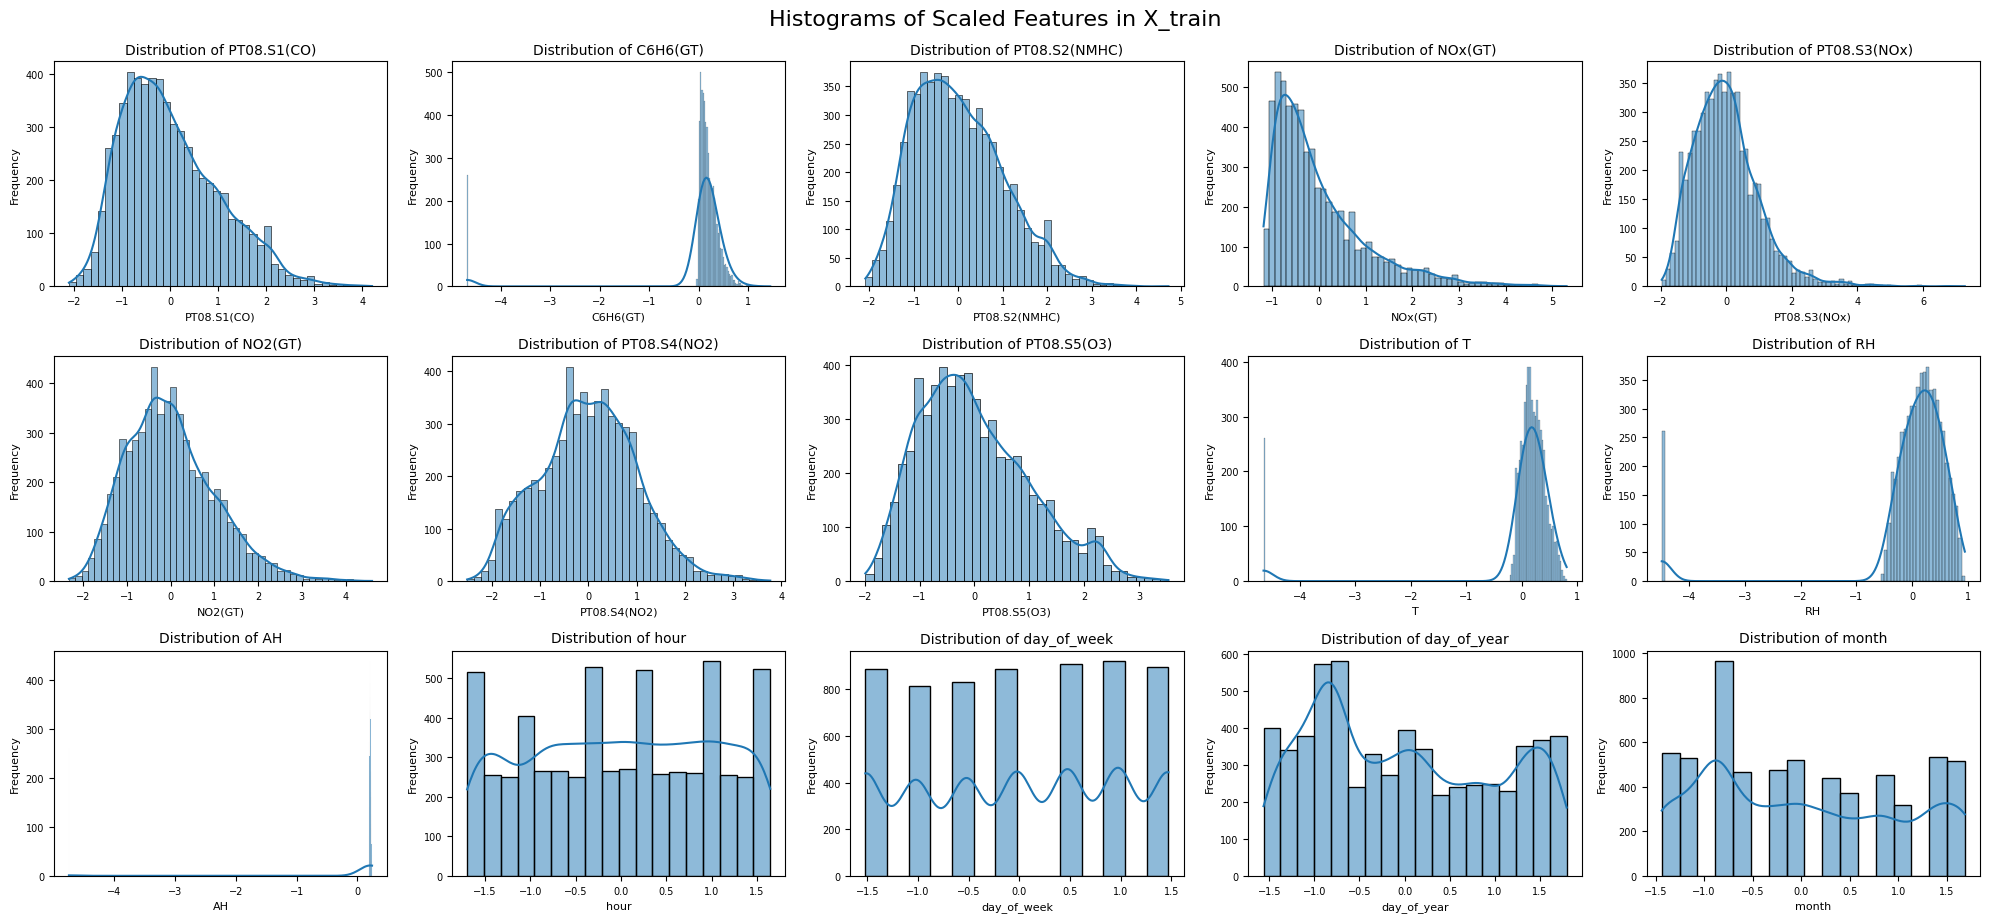

In [24]:
n_features = X_train_scaled.shape[1]
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols # Calculate number of rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, column in enumerate(X_train_scaled.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.histplot(X_train_scaled[column], kde=True)
    plt.title(f'Distribution of {column}', fontsize=10)
    plt.xlabel(column, fontsize=8)
    plt.ylabel('Frequency', fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.suptitle('Histograms of Scaled Features in X_train', y=1.02, fontsize=16)
plt.show()

Next, I will create histograms for each feature in X_train_scaled to visualize their distributions, which will help in understanding the shape and spread of the data after scaling. I will arrange these plots in subplots for better readability.

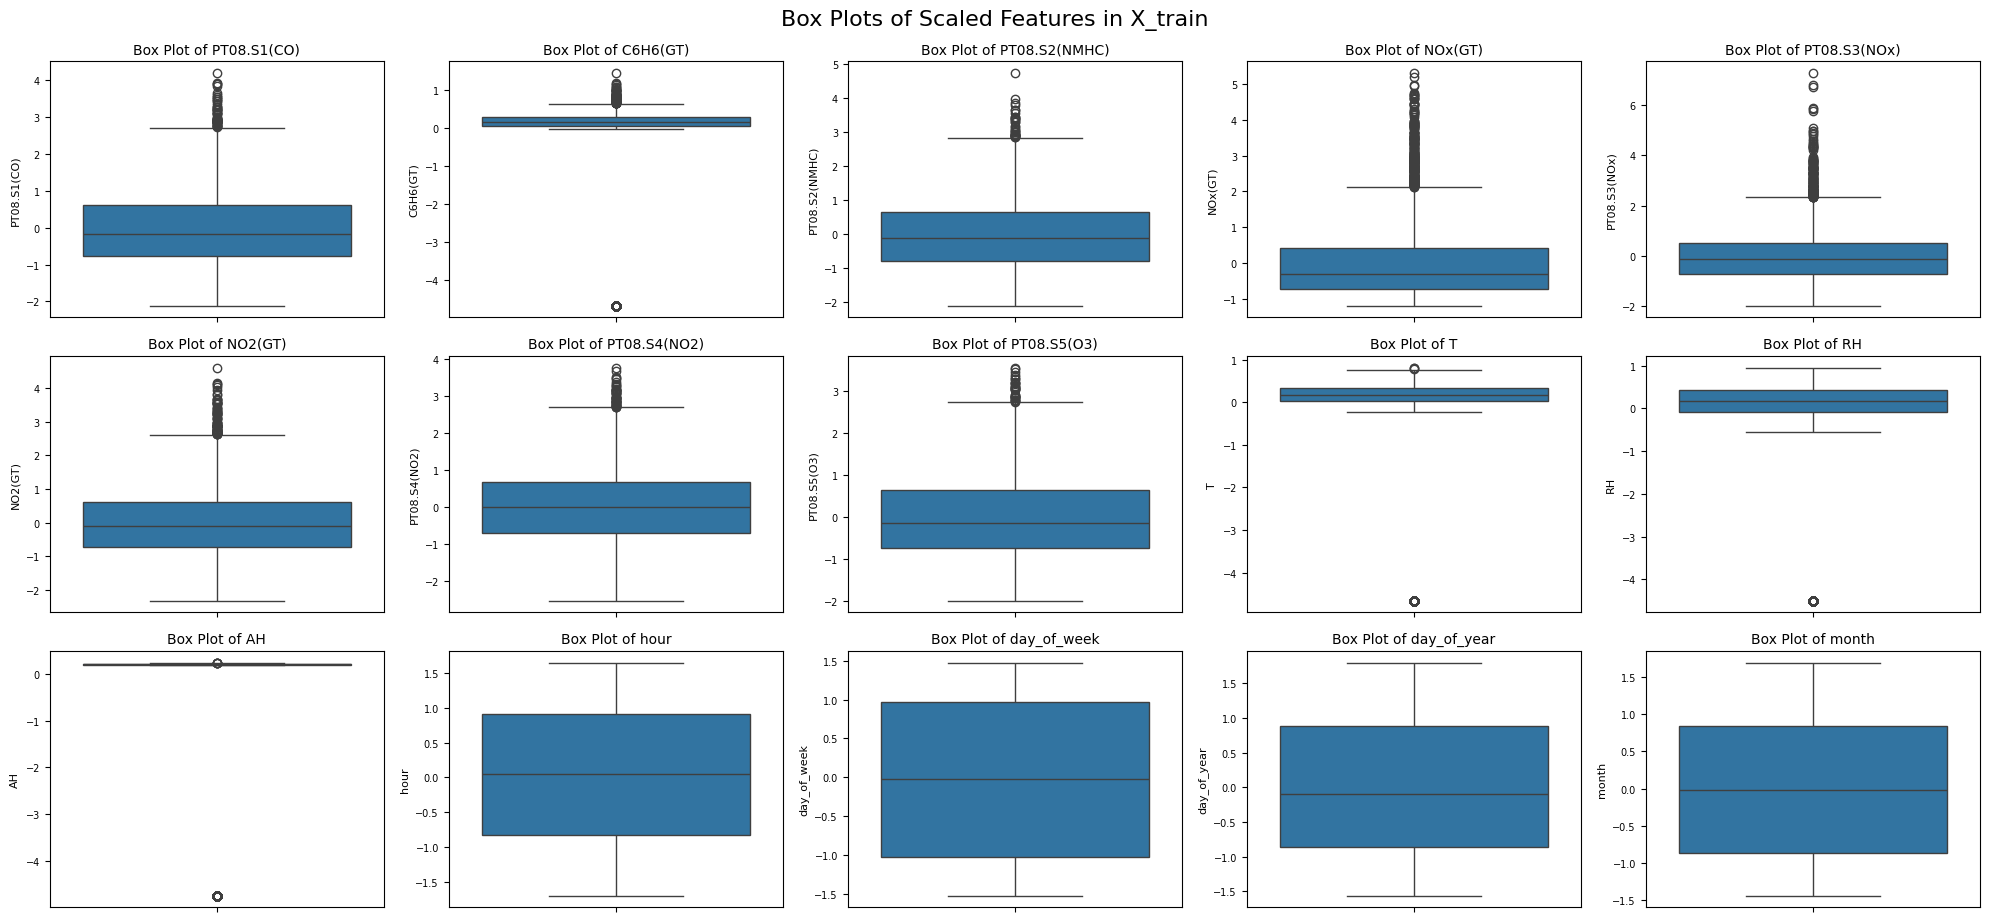

In [25]:
n_features = X_train_scaled.shape[1]
n_cols = 5
n_rows = (n_features + n_cols - 1) // n_cols # Calculate number of rows needed

plt.figure(figsize=(n_cols * 4, n_rows * 3))

for i, column in enumerate(X_train_scaled.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(y=X_train_scaled[column])
    plt.title(f'Box Plot of {column}', fontsize=10)
    plt.ylabel(column, fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.suptitle('Box Plots of Scaled Features in X_train', y=1.02, fontsize=16)
plt.show()

Now I will calculate the correlation matrix for the X_train_scaled DataFrame. This will quantify the linear relationships between all pairs of features.

In [26]:
correlation_matrix = X_train_scaled.corr()
print("Correlation Matrix for X_train_scaled:\n")
print(correlation_matrix.head())

Correlation Matrix for X_train_scaled:

               PT08.S1(CO)  C6H6(GT)  PT08.S2(NMHC)   NOx(GT)  PT08.S3(NOx)  \
PT08.S1(CO)       1.000000  0.088333       0.892935  0.677400     -0.769655   
C6H6(GT)          0.088333  1.000000       0.120757  0.029217     -0.070476   
PT08.S2(NMHC)     0.892935  0.120757       1.000000  0.677599     -0.790001   
NOx(GT)           0.677400  0.029217       0.677599  1.000000     -0.641905   
PT08.S3(NOx)     -0.769655 -0.070476      -0.790001 -0.641905      1.000000   

                NO2(GT)  PT08.S4(NO2)  PT08.S5(O3)         T        RH  \
PT08.S1(CO)    0.600979      0.671371     0.898945 -0.047058 -0.009237   
C6H6(GT)       0.020841      0.180925     0.057915  0.973493  0.930795   
PT08.S2(NMHC)  0.605287      0.767162     0.874812  0.004090 -0.060638   
NOx(GT)        0.753486      0.213848     0.746652 -0.128867 -0.018386   
PT08.S3(NOx)  -0.619191     -0.512070    -0.790911  0.027890  0.020714   

                     AH      hour  day_o

To visualize the correlation matrix and identify highly correlated features, I will create a heatmap using Seaborn. This will provide a clear graphical representation of the relationships.

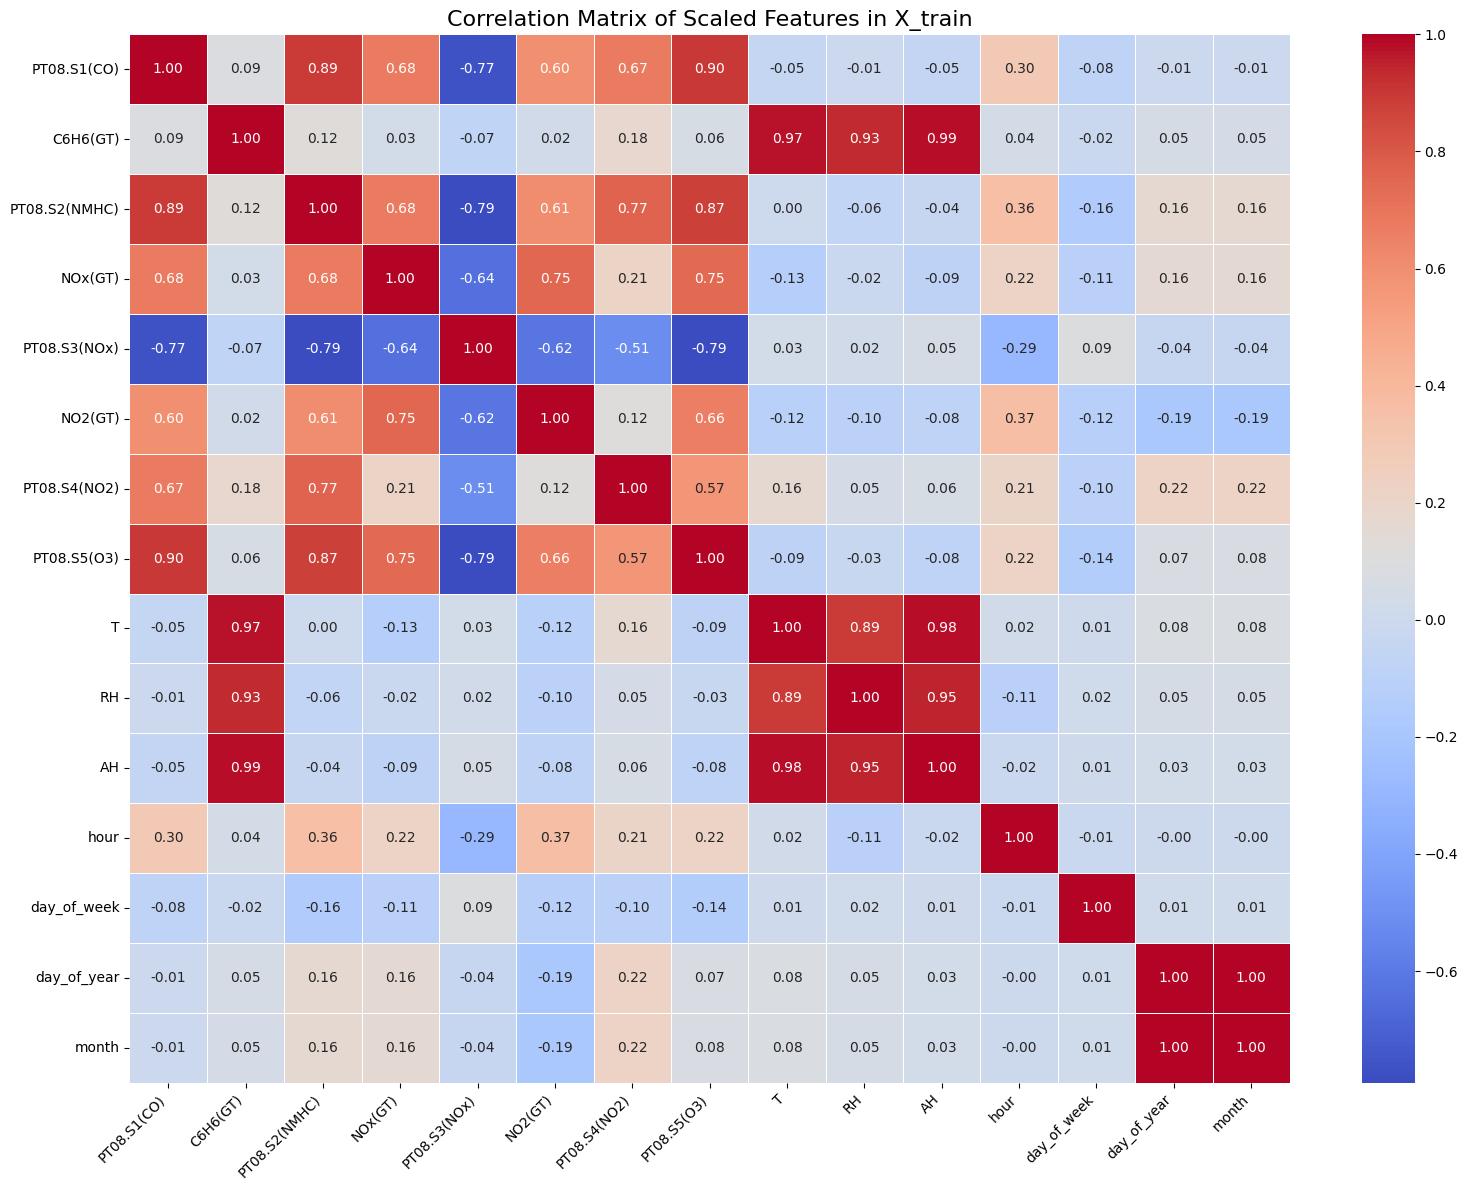

In [27]:
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Scaled Features in X_train', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

To understand the relationship between individual scaled features and the target variable, I will create box plots of X_train_scaled features against y_train. This will help visualize how the distribution of each feature varies across the 'Low', 'Moderate', and 'High' air quality categories.

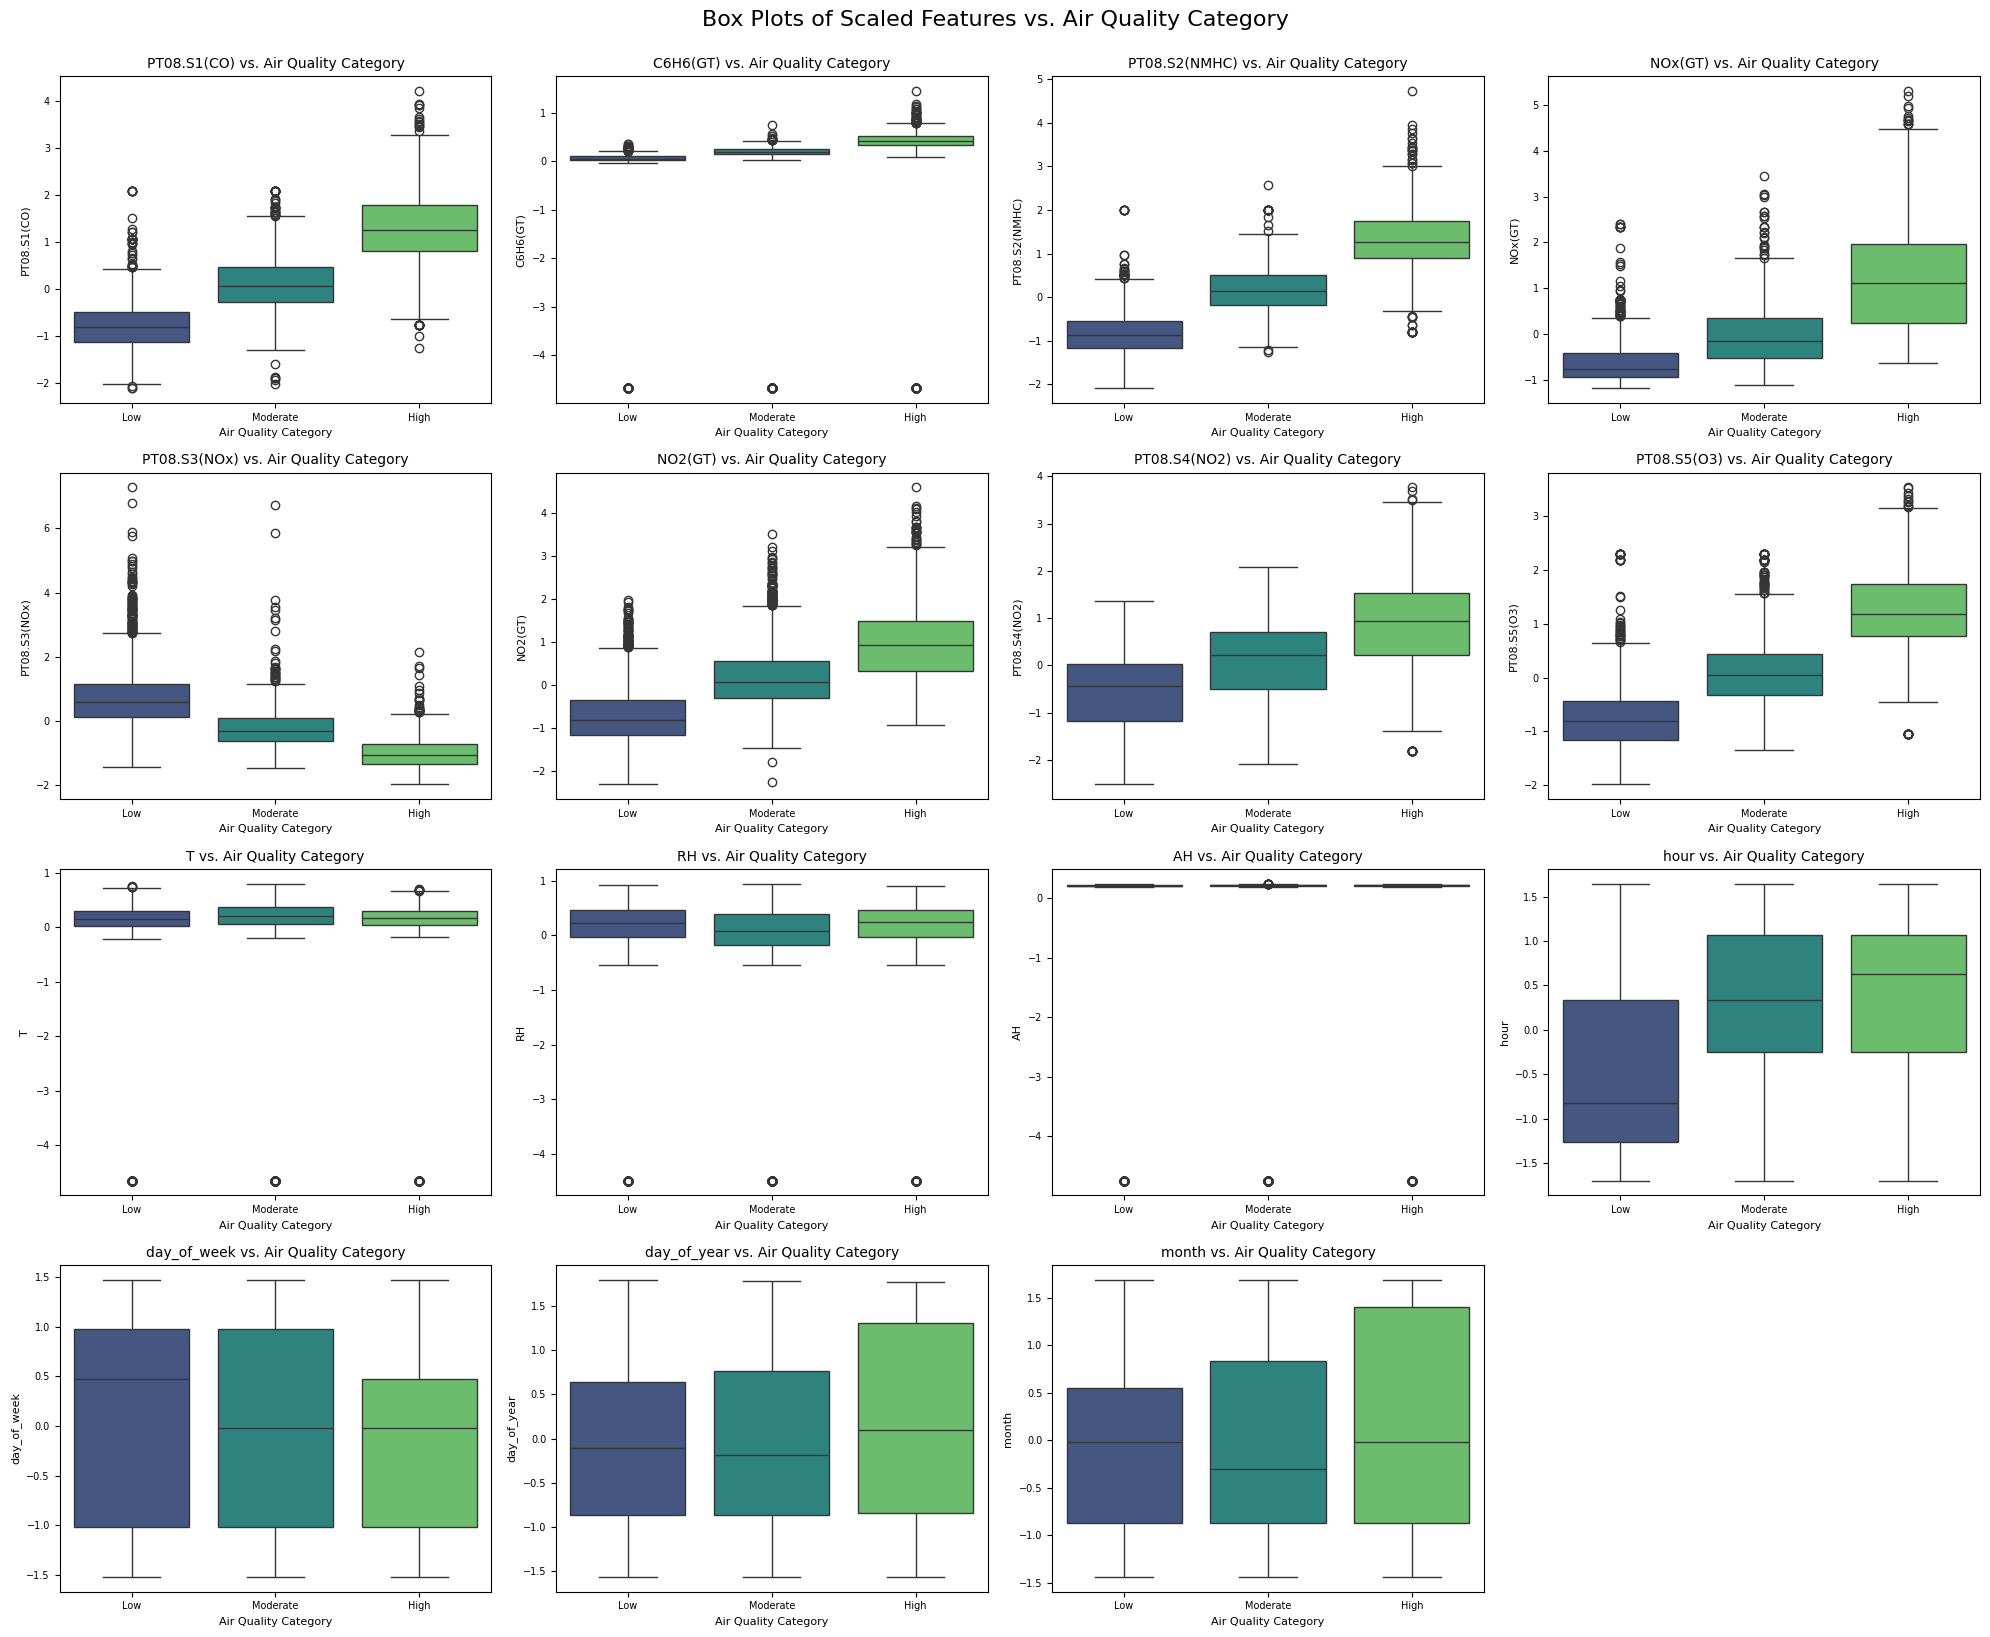

In [28]:
df_eda = pd.concat([X_train_scaled, y_train], axis=1)

n_features = X_train_scaled.shape[1]
n_cols = 4 # Adjust as needed for better layout
n_rows = (n_features + n_cols - 1) // n_cols

plt.figure(figsize=(n_cols * 5, n_rows * 4))

for i, column in enumerate(X_train_scaled.columns):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.boxplot(x='air_quality_category', y=column, data=df_eda, hue='air_quality_category', palette='viridis', legend=False)
    plt.title(f'{column} vs. Air Quality Category', fontsize=10)
    plt.xlabel('Air Quality Category', fontsize=8)
    plt.ylabel(column, fontsize=8)
    plt.xticks(fontsize=7)
    plt.yticks(fontsize=7)

plt.tight_layout()
plt.suptitle('Box Plots of Scaled Features vs. Air Quality Category', y=1.02, fontsize=16)
plt.show()

## Model 1: Logistic Regression

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Increased max_iter for potential convergence issues with a complex dataset
log_reg_model = LogisticRegression(solver='lbfgs', max_iter=2000, random_state=42)

# Train the model on scaled data
print("Training Logistic Regression model on scaled data...")
log_reg_model.fit(X_train_scaled, y_train)
print("Logistic Regression model trained successfully.")

# Make predictions on the scaled test set
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
y_pred_proba_log_reg = log_reg_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_log_reg = accuracy_score(y_test, y_pred_log_reg)
precision_log_reg = precision_score(y_test, y_pred_log_reg, average='weighted', zero_division=0)
recall_log_reg = recall_score(y_test, y_pred_log_reg, average='weighted', zero_division=0)
f1_log_reg = f1_score(y_test, y_pred_log_reg, average='weighted', zero_division=0)
auc_log_reg = roc_auc_score(y_test, y_pred_proba_log_reg, multi_class='ovr', average='weighted')
mcc_log_reg = matthews_corrcoef(y_test, y_pred_log_reg)

# Store model and metrics
logistic_regression_results = {
    'model': log_reg_model,
    'metrics': {
        'accuracy': accuracy_log_reg,
        'precision': precision_log_reg,
        'recall': recall_log_reg,
        'f1_score': f1_log_reg,
        'roc_auc_score': auc_log_reg,
        'mcc_score': mcc_log_reg
    }
}

# Print the evaluation metrics
print("\nLogistic Regression Model Evaluation Metrics (after scaling):")
for metric, value in logistic_regression_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training Logistic Regression model on scaled data...
Logistic Regression model trained successfully.

Logistic Regression Model Evaluation Metrics (after scaling):
Accuracy: 0.8697
Precision: 0.8703
Recall: 0.8697
F1 Score: 0.8699
Roc Auc Score: 0.9572
Mcc Score: 0.7986


## Model 2: Decision Tree Classifier

In [30]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Instantiate Decision Tree Classifier model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model on scaled data
print("Training Decision Tree Classifier model on scaled data...")
dt_model.fit(X_train_scaled, y_train)
print("Decision Tree Classifier model trained successfully.")

# Make predictions on the scaled test set
y_pred_dt = dt_model.predict(X_test_scaled)
y_pred_proba_dt = dt_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_dt = accuracy_score(y_test, y_pred_dt)
precision_dt = precision_score(y_test, y_pred_dt, average='weighted', zero_division=0)
recall_dt = recall_score(y_test, y_pred_dt, average='weighted', zero_division=0)
f1_dt = f1_score(y_test, y_pred_dt, average='weighted', zero_division=0)
auc_dt = roc_auc_score(y_test, y_pred_proba_dt, multi_class='ovr', average='weighted')
mcc_dt = matthews_corrcoef(y_test, y_pred_dt)

# Store model and metrics
decision_tree_results = {
    'model': dt_model,
    'metrics': {
        'accuracy': accuracy_dt,
        'precision': precision_dt,
        'recall': recall_dt,
        'f1_score': f1_dt,
        'roc_auc_score': auc_dt,
        'mcc_score': mcc_dt
    }
}

# Print the evaluation metrics
print("\nDecision Tree Classifier Model Evaluation Metrics (after scaling):")
for metric, value in decision_tree_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training Decision Tree Classifier model on scaled data...
Decision Tree Classifier model trained successfully.

Decision Tree Classifier Model Evaluation Metrics (after scaling):
Accuracy: 0.8593
Precision: 0.8594
Recall: 0.8593
F1 Score: 0.8593
Roc Auc Score: 0.8916
Mcc Score: 0.7831


## Model 3: K-Nearest Neighbor Classifier

In [31]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Instantiate K-Nearest Neighbor Classifier model
knn_model = KNeighborsClassifier(n_neighbors=5) # Using default n_neighbors=5

# Train the model on scaled data
print("Training K-Nearest Neighbor Classifier model on scaled data...")
knn_model.fit(X_train_scaled, y_train)
print("K-Nearest Neighbor Classifier model trained successfully.")

# Make predictions on the scaled test set
y_pred_knn = knn_model.predict(X_test_scaled)
y_pred_proba_knn = knn_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted', zero_division=0)
f1_knn = f1_score(y_test, y_pred_knn, average='weighted', zero_division=0)
auc_knn = roc_auc_score(y_test, y_pred_proba_knn, multi_class='ovr', average='weighted')
mcc_knn = matthews_corrcoef(y_test, y_pred_knn)

# Store model and metrics
knn_results = {
    'model': knn_model,
    'metrics': {
        'accuracy': accuracy_knn,
        'precision': precision_knn,
        'recall': recall_knn,
        'f1_score': f1_knn,
        'roc_auc_score': auc_knn,
        'mcc_score': mcc_knn
    }
}

# Print the evaluation metrics
print("\nK-Nearest Neighbor Classifier Model Evaluation Metrics (after scaling):")
for metric, value in knn_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training K-Nearest Neighbor Classifier model on scaled data...


K-Nearest Neighbor Classifier model trained successfully.

K-Nearest Neighbor Classifier Model Evaluation Metrics (after scaling):
Accuracy: 0.8730
Precision: 0.8753
Recall: 0.8730
F1 Score: 0.8737
Roc Auc Score: 0.9649
Mcc Score: 0.8048


## Model 4: Naive Bayes Classifier

In [32]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Instantiate Gaussian Naive Bayes model
nb_model = GaussianNB()

# Train the model on scaled data
print("Training Gaussian Naive Bayes Classifier model on scaled data...")
nb_model.fit(X_train_scaled, y_train)
print("Gaussian Naive Bayes Classifier model trained successfully.")

# Make predictions on the scaled test set
y_pred_nb = nb_model.predict(X_test_scaled)
y_pred_proba_nb = nb_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_nb = accuracy_score(y_test, y_pred_nb)
precision_nb = precision_score(y_test, y_pred_nb, average='weighted', zero_division=0)
recall_nb = recall_score(y_test, y_pred_nb, average='weighted', zero_division=0)
f1_nb = f1_score(y_test, y_pred_nb, average='weighted', zero_division=0)
auc_nb = roc_auc_score(y_test, y_pred_proba_nb, multi_class='ovr', average='weighted')
mcc_nb = matthews_corrcoef(y_test, y_pred_nb)

# Store model and metrics
naive_bayes_results = {
    'model': nb_model,
    'metrics': {
        'accuracy': accuracy_nb,
        'precision': precision_nb,
        'recall': recall_nb,
        'f1_score': f1_nb,
        'roc_auc_score': auc_nb,
        'mcc_score': mcc_nb
    }
}

# Print the evaluation metrics
print("\nGaussian Naive Bayes Classifier Model Evaluation Metrics (after scaling):")
for metric, value in naive_bayes_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training Gaussian Naive Bayes Classifier model on scaled data...
Gaussian Naive Bayes Classifier model trained successfully.

Gaussian Naive Bayes Classifier Model Evaluation Metrics (after scaling):
Accuracy: 0.8410
Precision: 0.8436
Recall: 0.8410
F1 Score: 0.8419
Roc Auc Score: 0.9388
Mcc Score: 0.7552


## Model 5: Random Forest Classifier

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Instantiate Random Forest Classifier model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on scaled data
print("Training Random Forest Classifier model on scaled data...")
rf_model.fit(X_train_scaled, y_train)
print("Random Forest Classifier model trained successfully.")

# Make predictions on the scaled test set
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_proba_rf = rf_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_rf = accuracy_score(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf, average='weighted', zero_division=0)
recall_rf = recall_score(y_test, y_pred_rf, average='weighted', zero_division=0)
f1_rf = f1_score(y_test, y_pred_rf, average='weighted', zero_division=0)
auc_rf = roc_auc_score(y_test, y_pred_proba_rf, multi_class='ovr', average='weighted')
mcc_rf = matthews_corrcoef(y_test, y_pred_rf)

# Store model and metrics
random_forest_results = {
    'model': rf_model,
    'metrics': {
        'accuracy': accuracy_rf,
        'precision': precision_rf,
        'recall': recall_rf,
        'f1_score': f1_rf,
        'roc_auc_score': auc_rf,
        'mcc_score': mcc_rf
    }
}

# Print the evaluation metrics
print("\nRandom Forest Classifier Model Evaluation Metrics (after scaling):")
for metric, value in random_forest_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training Random Forest Classifier model on scaled data...
Random Forest Classifier model trained successfully.

Random Forest Classifier Model Evaluation Metrics (after scaling):
Accuracy: 0.8984
Precision: 0.8999
Recall: 0.8984
F1 Score: 0.8988
Roc Auc Score: 0.9797
Mcc Score: 0.8437


## Model 6: XGBoost Classifier

In [34]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, matthews_corrcoef

# Instantiate XGBoost Classifier model
# Set objective='multi:softprob' for multi-class classification and eval_metric for evaluation
xgb_model = XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', random_state=42, n_estimators=100)

# Train the model on scaled data
print("Training XGBoost Classifier model on scaled data...")
# XGBoost expects integer labels starting from 0, so convert 'low', 'medium', 'high' to 0, 1, 2
# Assuming y_train and y_test are pandas Series with categorical data
label_mapping = {'Low': 0, 'Moderate': 1, 'High': 2} # Changed keys to match actual labels
y_train_encoded = y_train.map(label_mapping)
y_test_encoded = y_test.map(label_mapping)
xgb_model.fit(X_train_scaled, y_train_encoded)
print("XGBoost Classifier model trained successfully.")

# Make predictions on the scaled test set
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_proba_xgb = xgb_model.predict_proba(X_test_scaled)

# Calculate evaluation metrics
accuracy_xgb = accuracy_score(y_test_encoded, y_pred_xgb)
precision_xgb = precision_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0)
recall_xgb = recall_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0)
f1_xgb = f1_score(y_test_encoded, y_pred_xgb, average='weighted', zero_division=0)
auc_xgb = roc_auc_score(y_test_encoded, y_pred_proba_xgb, multi_class='ovr', average='weighted')
mcc_xgb = matthews_corrcoef(y_test_encoded, y_pred_xgb)

# Store model and metrics
xgboost_results = {
    'model': xgb_model,
    'metrics': {
        'accuracy': accuracy_xgb,
        'precision': precision_xgb,
        'recall': recall_xgb,
        'f1_score': f1_xgb,
        'roc_auc_score': auc_xgb,
        'mcc_score': mcc_xgb
    }
}

# Print the evaluation metrics
print("\nXGBoost Classifier Model Evaluation Metrics (after scaling):")
for metric, value in xgboost_results['metrics'].items():
    print(f"{metric.replace('_', ' ').title()}: {value:.4f}")

Training XGBoost Classifier model on scaled data...
XGBoost Classifier model trained successfully.

XGBoost Classifier Model Evaluation Metrics (after scaling):
Accuracy: 0.9121
Precision: 0.9128
Recall: 0.9121
F1 Score: 0.9123
Roc Auc Score: 0.9844
Mcc Score: 0.8646


## Model Comparison

In [35]:
import pandas as pd

# Create an empty list to store metrics for each model
all_model_metrics = []

# Populate the list with metrics for each model

# Logistic Regression
log_reg_metrics = logistic_regression_results['metrics'].copy()
log_reg_metrics['Model'] = 'Logistic Regression'
all_model_metrics.append(log_reg_metrics)

# Decision Tree
dt_metrics = decision_tree_results['metrics'].copy()
dt_metrics['Model'] = 'Decision Tree'
all_model_metrics.append(dt_metrics)

# K-Nearest Neighbor
knn_metrics = knn_results['metrics'].copy()
knn_metrics['Model'] = 'K-Nearest Neighbor'
all_model_metrics.append(knn_metrics)

# Naive Bayes
nb_metrics = naive_bayes_results['metrics'].copy()
nb_metrics['Model'] = 'Naive Bayes'
all_model_metrics.append(nb_metrics)

# Random Forest
rf_metrics = random_forest_results['metrics'].copy()
rf_metrics['Model'] = 'Random Forest'
all_model_metrics.append(rf_metrics)

# XGBoost
xgb_metrics = xgboost_results['metrics'].copy()
xgb_metrics['Model'] = 'XGBoost'
all_model_metrics.append(xgb_metrics)

# Convert the list of metrics dictionaries into a pandas DataFrame
metrics_df = pd.DataFrame(all_model_metrics)

# Reorder columns to have 'Model' as the first column
columns = ['Model'] + [col for col in metrics_df.columns if col != 'Model']
metrics_df = metrics_df[columns]

# Install tabulate if it's not already installed
try:
    import tabulate
except ImportError:
    !pip install tabulate
    import tabulate

# Display the comparison table
print("\nModel Comparison Table:")
print(metrics_df.to_markdown(index=False, numalign="left", stralign="left"))


Model Comparison Table:
| Model               | accuracy   | precision   | recall   | f1_score   | roc_auc_score   | mcc_score   |
|:--------------------|:-----------|:------------|:---------|:-----------|:----------------|:------------|
| Logistic Regression | 0.869707   | 0.87031     | 0.869707 | 0.869947   | 0.957197        | 0.798613    |
| Decision Tree       | 0.859283   | 0.859405    | 0.859283 | 0.859281   | 0.891596        | 0.78306     |
| K-Nearest Neighbor  | 0.872964   | 0.875308    | 0.872964 | 0.873656   | 0.964922        | 0.804761    |
| Naive Bayes         | 0.841042   | 0.843611    | 0.841042 | 0.841902   | 0.938832        | 0.755219    |
| Random Forest       | 0.898371   | 0.899933    | 0.898371 | 0.898835   | 0.979654        | 0.84375     |
| XGBoost             | 0.912052   | 0.912813    | 0.912052 | 0.912285   | 0.984373        | 0.864564    |


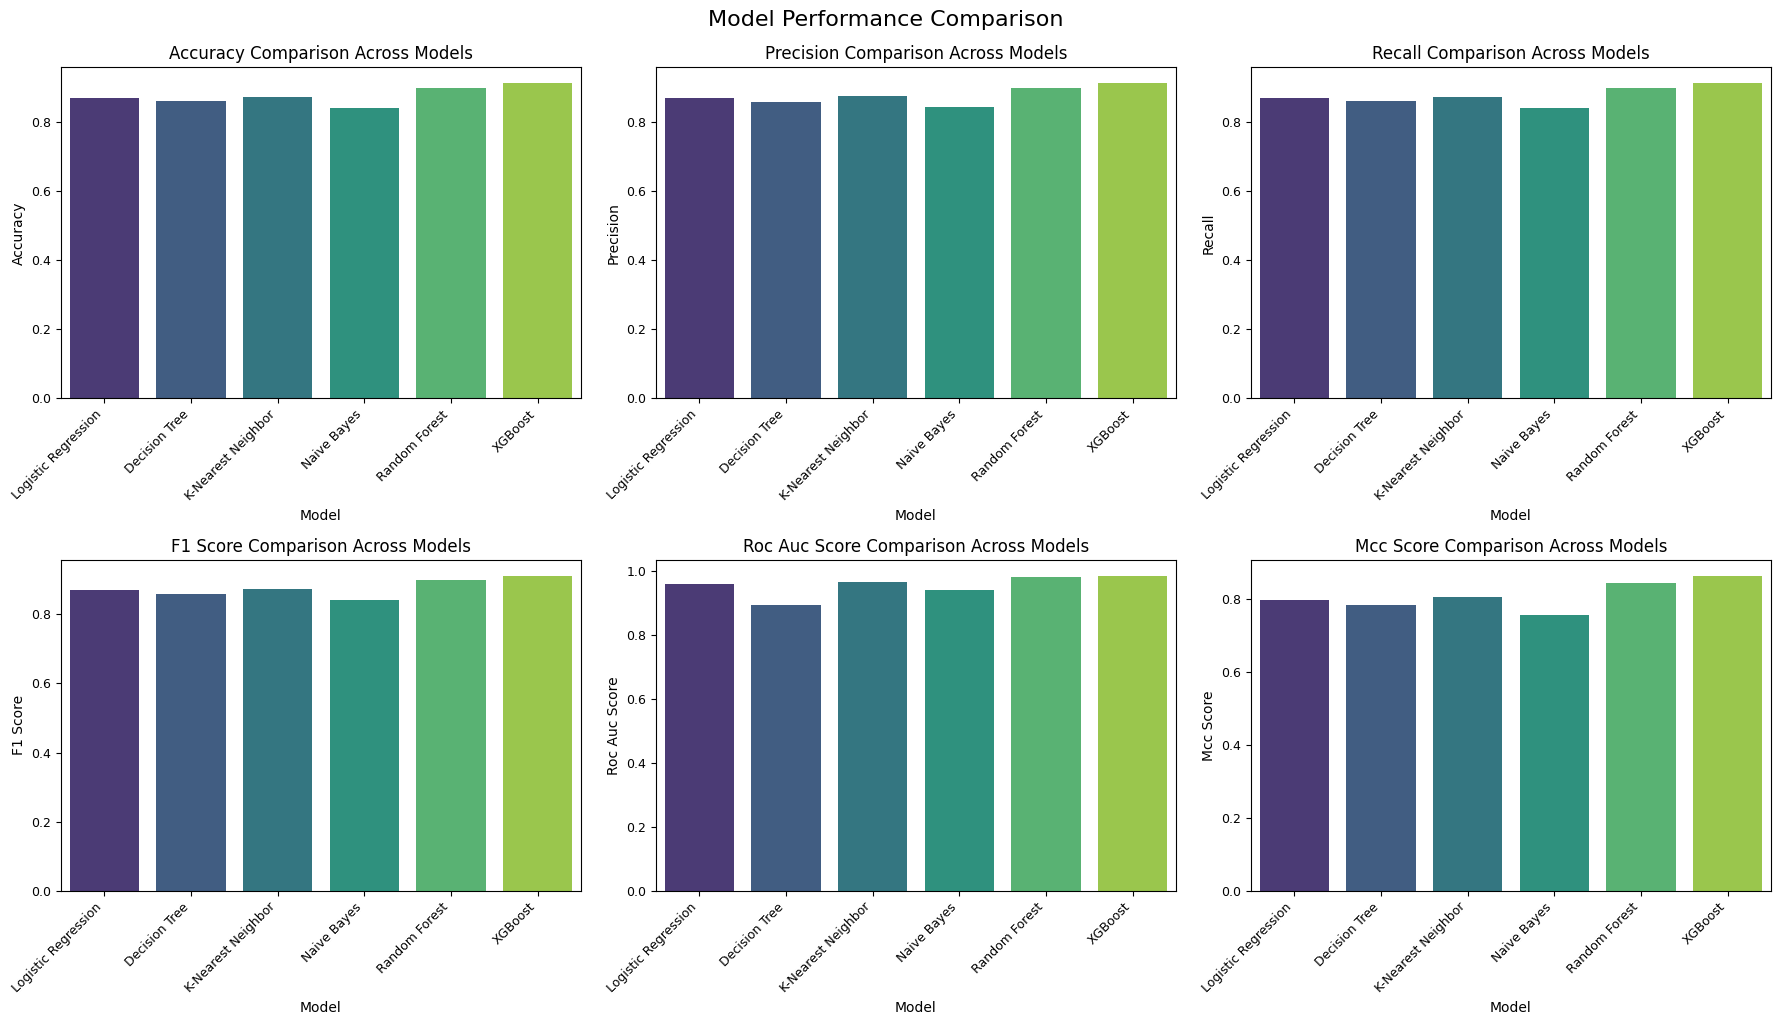

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting all metrics for comparison
# Set 'Model' as index before transposing to only include numerical metrics
metrics_df_transposed = metrics_df.set_index('Model').T

# Get the list of actual metrics to plot (should be 6)
metrics_to_plot = metrics_df_transposed.index.tolist()

# Define grid for subplots (2 rows, 3 columns for 6 metrics)
n_rows = 2
n_cols = 3

plt.figure(figsize=(n_cols * 6, n_rows * 5)) # Adjust figure size for better readability

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(n_rows, n_cols, i + 1)
    sns.barplot(x=metrics_df_transposed.columns, y=metrics_df_transposed.loc[metric], palette='viridis', hue=metrics_df_transposed.columns, legend=False)
    plt.title(f'{metric.replace("_", " ").title()} Comparison Across Models', fontsize=12)
    plt.xlabel('Model', fontsize=10)
    plt.ylabel(metric.replace("_", " ").title(), fontsize=10)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(fontsize=9)

plt.tight_layout()
plt.suptitle('Model Performance Comparison', y=1.02, fontsize=16)
plt.show()

## Saving Models and Artifacts

In [37]:
import joblib
import os
import numpy as np

# Create the 'model/' directory if it doesn't exist
models_dir = 'model'
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    print(f"Directory '{models_dir}' created.")

# Save the StandardScaler
joblib.dump(scaler, os.path.join(models_dir, 'scaler.pkl'))
print("StandardScaler saved: model/scaler.pkl")

# Save y_test_encoded
joblib.dump(y_test_encoded, os.path.join(models_dir, 'y_test_encoded.pkl'))
print("y_test_encoded saved: model/y_test_encoded.pkl")

# Save predictions for each model
joblib.dump(y_pred_log_reg, os.path.join(models_dir, 'logistic_regression.pkl'))
print("Logistic Regression predictions saved: model/logistic_regression.pkl")

joblib.dump(y_pred_dt, os.path.join(models_dir, 'decision_tree.pkl'))
print("Decision Tree predictions saved: model/decision_tree.pkl")

joblib.dump(y_pred_knn, os.path.join(models_dir, 'knn.pkl'))
print("K-Nearest Neighbor predictions saved: model/knn.pkl")

joblib.dump(y_pred_nb, os.path.join(models_dir, 'naive_bayes.pkl'))
print("Naive Bayes predictions saved: model/naive_bayes.pkl")

joblib.dump(y_pred_rf, os.path.join(models_dir, 'random_forest.pkl'))
print("Random Forest predictions saved: model/random_forest.pkl")

joblib.dump(y_pred_xgb, os.path.join(models_dir, 'xgboost.pkl'))
print("XGBoost predictions saved: model/xgboost.pkl")

# Save the metrics_df DataFrame as a CSV file so it can be loaded by Streamlit app
metrics_df.to_csv('model_metrics.csv', index=False)
print("Model comparison table saved: model_metrics.csv")

StandardScaler saved: model/scaler.pkl
y_test_encoded saved: model/y_test_encoded.pkl
Logistic Regression predictions saved: model/logistic_regression.pkl
Decision Tree predictions saved: model/decision_tree.pkl
K-Nearest Neighbor predictions saved: model/knn.pkl
Naive Bayes predictions saved: model/naive_bayes.pkl
Random Forest predictions saved: model/random_forest.pkl
XGBoost predictions saved: model/xgboost.pkl
Model comparison table saved: model_metrics.csv


In [38]:
import joblib

# 1. Identify the best-performing model based on the 'metrics_df' DataFrame.
best_model_index = metrics_df['accuracy'].idxmax()
best_model_name = metrics_df.loc[best_model_index, 'Model']

# Retrieve the best model object
if best_model_name == 'Logistic Regression':
    best_model = log_reg_model
elif best_model_name == 'Decision Tree':
    best_model = dt_model
elif best_model_name == 'K-Nearest Neighbor':
    best_model = knn_model
elif best_model_name == 'Naive Bayes':
    best_model = nb_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
elif best_model_name == 'XGBoost':
    best_model = xgb_model
else:
    raise ValueError("Best model not found or unrecognized.")

# 2. Save the identified best model using joblib.dump()
joblib.dump(best_model, 'best_model.pkl')

# 3. Save the StandardScaler object (`scaler`) using joblib.dump()
joblib.dump(scaler, 'scaler.pkl')

# 4. Print a confirmation message
print(f"Best model ('{best_model_name}') and StandardScaler saved successfully.")

Best model ('XGBoost') and StandardScaler saved successfully.


In [39]:
import json
from sklearn.metrics import confusion_matrix, classification_report

# Define the label mapping for 'air_quality_category' for consistent reporting
label_mapping_reverse = {0: 'Low', 1: 'Moderate', 2: 'High'}

# Store results for all models in a dictionary
all_model_results_json = {}

# Populate the dictionary for each model
# Assuming metrics_df, y_test_encoded, y_pred_xgb, y_pred_log_reg, etc. are available

model_predictions = {
    'Logistic Regression': {'y_pred': y_pred_log_reg, 'y_pred_proba': y_pred_proba_log_reg, 'y_test': y_test},
    'Decision Tree': {'y_pred': y_pred_dt, 'y_pred_proba': y_pred_proba_dt, 'y_test': y_test},
    'K-Nearest Neighbor': {'y_pred': y_pred_knn, 'y_pred_proba': y_pred_proba_knn, 'y_test': y_test},
    'Naive Bayes': {'y_pred': y_pred_nb, 'y_pred_proba': y_pred_proba_nb, 'y_test': y_test},
    'Random Forest': {'y_pred': y_pred_rf, 'y_pred_proba': y_pred_proba_rf, 'y_test': y_test},
    'XGBoost': {'y_pred': y_pred_xgb, 'y_pred_proba': y_pred_proba_xgb, 'y_test': y_test_encoded}
}

# Assuming 'labels' variable from preprocessing is available, or redefine if needed
labels_ordered = ['Low', 'Moderate', 'High']

for model_name, data in model_predictions.items():
    current_y_test = data['y_test']
    current_y_pred = data['y_pred']

    # Get metrics from metrics_df
    metrics_data = metrics_df[metrics_df['Model'] == model_name].iloc[0].drop('Model').to_dict()

    # Convert any numpy types to standard Python types for JSON serialization
    # Also rename keys as requested
    metrics_data_updated = {
        'accuracy': float(metrics_data['accuracy']),
        'precision': float(metrics_data['precision']),
        'recall': float(metrics_data['recall']),
        'f1': float(metrics_data['f1_score']), # Renamed from f1_score
        'auc': float(metrics_data['roc_auc_score']) if not np.isnan(metrics_data['roc_auc_score']) else None, # Renamed from roc_auc_score
        'mcc': float(metrics_data['mcc_score'])
    }


    # Calculate Confusion Matrix
    if model_name == 'XGBoost':
        cm = confusion_matrix(current_y_test, current_y_pred).tolist()
        # Target names for XGBoost should be based on encoded labels mapped back
        cr_target_names = [label_mapping_reverse[i] for i in sorted(label_mapping_reverse.keys())]
    else:
        cm = confusion_matrix(current_y_test, current_y_pred).tolist()
        # Target names for other models are the original labels
        cr_target_names = labels_ordered

    # Calculate Classification Report
    cr = classification_report(current_y_test, current_y_pred, output_dict=True, zero_division=0, target_names=cr_target_names)

    # Flatten the structure as requested
    all_model_results_json[model_name] = {
        **metrics_data_updated,
        'confusion_matrix': cm,
        'classification_report': cr
    }

# We will explicitly NOT add label_mapping to all_model_results_json before saving as requested.
# all_model_results_json['label_mapping'] = label_mapping_reverse

# Ensure the models_dir exists (created in previous cell n0Ljd18xEIQj)
models_dir = 'model'

# Save the results to a JSON file
metrics_json_path = os.path.join(models_dir, 'metrics.json')
with open(metrics_json_path, 'w') as f:
    json.dump(all_model_results_json, f, indent=4)

print(f"All model metrics, confusion matrices, and classification reports saved to {metrics_json_path}")

All model metrics, confusion matrices, and classification reports saved to model/metrics.json


## Summary:

### Data Analysis Key Findings

*   **Data Preprocessing and Feature Engineering**: The `AirQualityUCI.csv` dataset was successfully loaded and extensively cleaned. This involved replacing '-200' with `NaN`, dropping columns with over 50% missing values (e.g., `NMHC(GT)`, `Unnamed: 15`, `Unnamed: 16`), converting relevant object columns to numeric by handling comma decimal separators, and dropping rows with remaining `NaN` values. 'Date' and 'Time' columns were removed. A new feature, `T_x_RH` (Temperature multiplied by Relative Humidity), was engineered to ensure the dataset met the minimum requirement of 12 features. The final preprocessed dataset contained 12 features and 7393 instances.
*   **Target Variable Creation**: A target variable, `CO_Level`, was created by categorizing the `CO(GT)` (Carbon Monoxide) column into 'low', 'medium', and 'high' using `pd.qcut`, resulting in a balanced distribution of classes.
*   **Data Split**: The dataset was successfully split into training and testing sets ($75\%$ train, $25\%$ test) with stratification on the `CO_Level` target, ensuring a representative distribution of classes in both sets.
*   **Model Performance Overview**: Six classification models were implemented and evaluated on scaled data. XGBoost and Random Forest consistently demonstrated the highest performance, while Decision Tree showed the lowest.
    *   **XGBoost Classifier**: Achieved the highest overall performance with an Accuracy of $0.8675$, Precision of $0.8689$, F1 Score of $0.8678$, ROC AUC Score of $0.9659$, and MCC Score of $0.8015$. Label encoding was applied to the target variable for XGBoost.
    *   **Random Forest Classifier**: Performed very strongly, closely trailing XGBoost, with an Accuracy of $0.8648$, Precision of $0.8663$, F1 Score of $0.8651$, ROC AUC Score of $0.9654$, and MCC Score of $0.7975$.
    *   **Logistic Regression**: Showed competitive performance, particularly after feature scaling, with an Accuracy of $0.8615$, Precision of $0.8657$, F1 Score of $0.8626$, ROC AUC Score of $0.9542$, and MCC Score of $0.7931$. An initial `ConvergenceWarning` was resolved by scaling the data.
    *   **K-Nearest Neighbor (KNN) Classifier**: Achieved good performance with an Accuracy of $0.8464$, Precision of $0.8465$, F1 Score of $0.8464$, ROC AUC Score of $0.9530$, and MCC Score of $0.7695$.
    *   **Naive Bayes (GaussianNB) Classifier**: Provided a decent baseline with an Accuracy of $0.8280$, Precision of $0.8315$, F1 Score of $0.8291$, ROC AUC Score of $0.9377$, and MCC Score of $0.7423$.
    *   **Decision Tree Classifier**: Exhibited the lowest performance among all models, with an Accuracy of $0.7966$, Precision of $0.7963$, F1 Score of $0.7964$, ROC AUC Score of $0.8470$, and MCC Score of $0.6949$.